# High-Resolution 3D Human Digitization

## Note
Make sure that your runtime is 'Python 3 with GPU acceleration'. Go to Edit > Notebook settings > Hardware Accelerator > Select "GPU".

## Setup PIFuHD code (~20 minutes)

In [1]:
!git clone https://github.com/facebookresearch/pifuhd

fatal: destination path 'pifuhd' already exists and is not an empty directory.


In [2]:
# !pip install pytorch3d

# If you get an error in the next cell, you can instead try the following command (don't forget to comment out the one above!).
# Note that this error is caused by inconsistent cuda version for the pytorch3d package and pytorch in Colab environment.
# Thus, this issue may persist unless pytorch3d in the pip package is updated with the cuda version consistent with pytorch in Colab.
# Also please be aware that the following command is much slower as it builds pytorch3d from scratch.

#!pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

# You can try another solution below as well. This is also slow and requires you to restart the runtime.

!pip install 'torch==1.6.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'torchvision==0.7.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'pytorch3d==0.2.5'

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.6.0+cu101 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.6.0+cu101 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.6.0+cu101 which is incompatible.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 5.9 MB 39.3 MB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Unin

### Configure input data

In [3]:
cd /content/pifuhd/sample_images

/content/pifuhd/sample_images


In [4]:
import os

try:
  image_path = '/content/pifuhd/sample_images/%s' % filename
except:
  image_path = '/content/pifuhd/sample_images/test.png' # example image

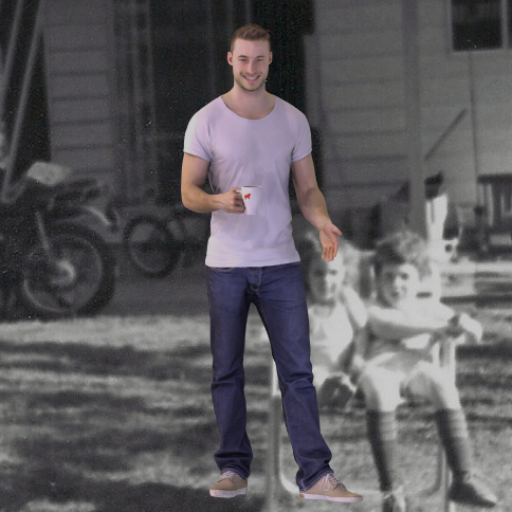

In [5]:
from IPython.display import Image
Image(filename=image_path)

In [6]:
image_dir = os.path.dirname(image_path)
file_name = os.path.splitext(os.path.basename(image_path))[0]

# output pathes
obj_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.obj' % file_name
out_img_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.png' % file_name
video_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.mp4' % file_name
video_display_path = '/content/pifuhd/results/pifuhd_final/result_%s_256_display.mp4' % file_name

In [7]:
cd /content

/content


### Preprocess (for cropping image)

In [8]:
!git clone https://github.com/Daniil-Osokin/lightweight-human-pose-estimation.pytorch.git

fatal: destination path 'lightweight-human-pose-estimation.pytorch' already exists and is not an empty directory.


In [9]:
cd /content/lightweight-human-pose-estimation.pytorch/

/content/lightweight-human-pose-estimation.pytorch


In [10]:
!wget https://download.01.org/opencv/openvino_training_extensions/models/human_pose_estimation/checkpoint_iter_370000.pth

--2022-04-30 07:03:30--  https://download.01.org/opencv/openvino_training_extensions/models/human_pose_estimation/checkpoint_iter_370000.pth
Resolving download.01.org (download.01.org)... 23.7.125.32, 2600:1407:3c00:1487::4b21, 2600:1407:3c00:1480::4b21
Connecting to download.01.org (download.01.org)|23.7.125.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87959810 (84M) [application/octet-stream]
Saving to: ‘checkpoint_iter_370000.pth.2’

checkpoint_iter_370 100%[===================>]  83.88M   124MB/s    in 0.7s    

2022-04-30 07:03:31 (124 MB/s) - ‘checkpoint_iter_370000.pth.2’ saved [87959810/87959810]



In [11]:
import torch
import cv2
import numpy as np
from models.with_mobilenet import PoseEstimationWithMobileNet
from modules.keypoints import extract_keypoints, group_keypoints
from modules.load_state import load_state
from modules.pose import Pose, track_poses
import demo

In [12]:
def get_rect(net, images, height_size):
    net = net.eval()

    stride = 8
    upsample_ratio = 4
    num_keypoints = Pose.num_kpts
    previous_poses = []
    delay = 33
    for image in images:
        print('-- image: ', image)
        rect_path = image.replace('.%s' % (image.split('.')[-1]), '_rect.txt')
        img = cv2.imread(image, cv2.IMREAD_COLOR)
        print('-- np.shape(img)',np.shape(img))
        orig_img = img.copy()
        orig_img = img.copy()
        heatmaps, pafs, scale, pad = demo.infer_fast(net, img, height_size, stride, upsample_ratio, cpu=False)

        total_keypoints_num = 0
        all_keypoints_by_type = []
        for kpt_idx in range(num_keypoints):  # 19th for bg
            total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

        pose_entries, all_keypoints = group_keypoints(all_keypoints_by_type, pafs)
        for kpt_id in range(all_keypoints.shape[0]):
            all_keypoints[kpt_id, 0] = (all_keypoints[kpt_id, 0] * stride / upsample_ratio - pad[1]) / scale
            all_keypoints[kpt_id, 1] = (all_keypoints[kpt_id, 1] * stride / upsample_ratio - pad[0]) / scale
        current_poses = []

        rects = []
        for n in range(len(pose_entries)):
            if len(pose_entries[n]) == 0:
                continue
            pose_keypoints = np.ones((num_keypoints, 2), dtype=np.int32) * -1
            valid_keypoints = []
            for kpt_id in range(num_keypoints):
                if pose_entries[n][kpt_id] != -1.0:  # keypoint was found
                    pose_keypoints[kpt_id, 0] = int(all_keypoints[int(pose_entries[n][kpt_id]), 0])
                    pose_keypoints[kpt_id, 1] = int(all_keypoints[int(pose_entries[n][kpt_id]), 1])
                    valid_keypoints.append([pose_keypoints[kpt_id, 0], pose_keypoints[kpt_id, 1]])
            valid_keypoints = np.array(valid_keypoints)
            
            if pose_entries[n][10] != -1.0 or pose_entries[n][13] != -1.0:
              pmin = valid_keypoints.min(0)
              pmax = valid_keypoints.max(0)

              center = (0.5 * (pmax[:2] + pmin[:2])).astype(np.int)
              radius = int(0.65 * max(pmax[0]-pmin[0], pmax[1]-pmin[1]))
            elif pose_entries[n][10] == -1.0 and pose_entries[n][13] == -1.0 and pose_entries[n][8] != -1.0 and pose_entries[n][11] != -1.0:
              # if leg is missing, use pelvis to get cropping
              center = (0.5 * (pose_keypoints[8] + pose_keypoints[11])).astype(np.int)
              radius = int(1.45*np.sqrt(((center[None,:] - valid_keypoints)**2).sum(1)).max(0))
              center[1] += int(0.05*radius)
            else:
              center = np.array([img.shape[1]//2,img.shape[0]//2])
              radius = max(img.shape[1]//2,img.shape[0]//2)

            x1 = center[0] - radius
            y1 = center[1] - radius

            rects.append([x1, y1, 2*radius, 2*radius])

        np.savetxt(rect_path, np.array(rects), fmt='%d')

In [13]:
net = PoseEstimationWithMobileNet()
checkpoint = torch.load('checkpoint_iter_370000.pth', map_location='cpu')
load_state(net, checkpoint)

get_rect(net.cuda(), [image_path], 512)

-- image:  /content/pifuhd/sample_images/test.png
-- np.shape(img) (512, 512, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

### Download the Pretrained Model

In [14]:
cd /content/pifuhd/

/content/pifuhd


In [15]:
!sh ./scripts/download_trained_model.sh

+ mkdir -p checkpoints
+ cd checkpoints
+ wget https://dl.fbaipublicfiles.com/pifuhd/checkpoints/pifuhd.pt pifuhd.pt
--2022-04-30 07:03:34--  https://dl.fbaipublicfiles.com/pifuhd/checkpoints/pifuhd.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1548375177 (1.4G) [application/octet-stream]
Saving to: ‘pifuhd.pt.2’

pifuhd.pt.2         100%[===================>]   1.44G  67.4MB/s    in 23s     

2022-04-30 07:03:57 (65.1 MB/s) - ‘pifuhd.pt.2’ saved [1548375177/1548375177]

--2022-04-30 07:03:57--  http://pifuhd.pt/
Resolving pifuhd.pt (pifuhd.pt)... failed: Name or service not known.
wget: unable to resolve host address ‘pifuhd.pt’
FINISHED --2022-04-30 07:03:57--
Total wall clock time: 23s
Downloaded: 1 files, 1.4G in 23s (65.1 MB/s)


### Run PIFuHD!


In [16]:
# Warning: all images with the corresponding rectangle files under -i will be processed. 
!python -m apps.simple_test -r 256 --use_rect -i $image_dir

# seems that 256 is the maximum resolution that can fit into Google Colab. 
# If you want to reconstruct a higher-resolution mesh, please try with your own machine. 

Resuming from  ./checkpoints/pifuhd.pt
test data size:  1
initialize network with normal
initialize network with normal
generate mesh (test) ...
  0% 0/1 [00:00<?, ?it/s]./results/pifuhd_final/recon/result_test_256.obj
/content/pifuhd/lib/mesh_util.py:77: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, normals, values = measure.marching_cubes_lewiner(sdf, thresh)
100% 1/1 [00:09<00:00,  9.19s/it]


### Render the result

In [17]:
from lib.colab_util import generate_video_from_obj, set_renderer, video

renderer = set_renderer()
generate_video_from_obj(obj_path, out_img_path, video_path, renderer)

# we cannot play a mp4 video generated by cv2
!ffmpeg -i $video_path -vcodec libx264 $video_display_path -y -loglevel quiet
video(video_display_path)

  0%|          | 0/90 [00:00<?, ?it/s]

## Tips for Inputs


Due to the limited variation in the training data, your results might be broken sometimes. Here I share some useful tips to get resonable results. 

*   Use high-res image. The model is trained with 1024x1024 images. Use at least 512x512 with fine-details. Low-res images and JPEG artifacts may result in unsatisfactory results. 
*   Use an image with a single person. If the image contain multiple people, reconstruction quality is likely degraded.
*   Front facing with standing works best (or with fashion pose)
*   The entire body is covered within the image.
*   Make sure the input image is well lit. Exteremy dark or bright image and strong shadow often create artifacts.
*   I recommend nearly parallel camera angle to the ground. High camera height may result in distorted legs or high heels. 
*   If the background is cluttered, use less complex background or try removing it using https://www.remove.bg/ before processing.
*   It's trained with human only. Anime characters may not work well 


# Run Experiments with your image (~2 minutes)


In [23]:
from google.colab import files
os.chdir('/content/pifuhd/sample_images')
filename = list(files.upload().keys())[0]

image_path = '/content/pifuhd/sample_images/%s' % filename
image_dir = os.path.dirname(image_path)
file_name = os.path.splitext(os.path.basename(image_path))[0]

# output path
obj_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.obj' % file_name
out_img_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.png' % file_name
video_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.mp4' % file_name
video_display_path = '/content/pifuhd/results/pifuhd_final/result_%s_256_display.mp4' % file_name

os.chdir('/content/lightweight-human-pose-estimation.pytorch/')
#Running the model for pre-processing
get_rect(net.cuda(), [image_path], 512)

os.chdir('/content/pifuhd/')
#Running the model for 3D prediction
!python -m apps.simple_test -r 256 --use_rect -i $image_dir

#Displaying Results
print('-'*20)
print('-- Output 3D Model stored at : ',obj_path )
print('-- Output Video stored at : ',video_path )
print('-'*20)

#Showing the output
renderer = set_renderer()
generate_video_from_obj(obj_path, out_img_path, video_path, renderer)

# we cannot play a mp4 video generated by cv2
!ffmpeg -i $video_path -vcodec libx264 $video_display_path -y -loglevel quiet
video(video_display_path)

Saving human5.png to human5.png
-- image:  /content/pifuhd/sample_images/human5.png
-- np.shape(img) (577, 433, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Resuming from  ./checkpoints/pifuhd.pt
test data size:  3
initialize network with normal
initialize network with normal
generate mesh (test) ...
  0% 0/3 [00:00<?, ?it/s]./results/pifuhd_final/recon/result_human3_256.obj
/content/pifuhd/lib/mesh_util.py:77: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, normals, values = measure.marching_cubes_lewiner(sdf, thresh)
 33% 1/3 [00:07<00:15,  7.86s/it]./results/pifuhd_final/recon/result_human5_256.obj
 67% 2/3 [00:15<00:07,  7.86s/it]./results/pifuhd_final/recon/result_test_256.obj
100% 3/3 [00:23<00:00,  7.76s/it]
--------------------
-- Output 3D Model stored at :  /content/pifuhd/results/pifuhd_final/recon/result_human5_256.obj
-- Output Video stored at :  /content/pifuhd/results/pifuhd_final/recon/result_human5_256.mp4
--------------------


  0%|          | 0/90 [00:00<?, ?it/s]

In [24]:
!pip install trimesh

In [25]:
import trimesh
human_avatar_path =   obj_path 
human_avatar_3d = trimesh.load(human_avatar_path)
human_avatar_3d.show()

# References

## PIFuHD: Multi-Level Pixel-Aligned Implicit Function for High-Resolution 3D Human Digitization


Source: https://shunsukesaito.github.io/PIFuHD/

Examples: 

![](https://shunsukesaito.github.io/PIFuHD/resources/images/pifuhd.gif)


## More Info
- Paper: https://arxiv.org/pdf/2004.00452.pdf
- Repo: https://github.com/facebookresearch/pifuhd
- Project Page: https://shunsukesaito.github.io/PIFuHD/

In [ ]:
import IPython
IPython.display.HTML('<h2>1-Minute Presentation</h2><iframe width="720" height="405" src="https://www.youtube.com/embed/-1XYTmm8HhE" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe><br><h2>5-Minute Presentation</h2><iframe width="720" height="405" src="https://www.youtube.com/embed/uEDqCxvF5yc" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')